In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [2]:
train_set='/kaggle/input/SAVE/train'
val_set='/kaggle/input/SAVE/val'
test_set='/kaggle/input/SAVE/test'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical')

Found 4535 images belonging to 8 classes.
Found 1294 images belonging to 8 classes.
Found 661 images belonging to 8 classes.


In [5]:
train_generator.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load ResNet50 as base model with ImageNet weights and excluding the top layer
base_model_resnet50 = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)

# Freeze the layers in the base model
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Create the model
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(GaussianNoise(0.35))
model_resnet50.add(GlobalAveragePooling2D())
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(BatchNormalization())
model_resnet50.add(GaussianNoise(0.35))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(8, activation='softmax'))

# Print model summary
model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,115,336 (91.99 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [7]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
checkpoint = ModelCheckpoint('bestx_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [10]:
history = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 162s 507ms/step - AUC: 0.8238 - Precision: 0.5356 - Recall: 0.3456 - accuracy: 0.4555 - loss: 1.5681 - val_AUC: 0.9668 - val_Precision: 0.7843 - val_Recall: 0.6930 - val_accuracy: 0.7461 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 2/300
  1/283 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - AUC: 0.9467 - Precision: 0.7857 - Recall: 0.6875 - accuracy: 0.6875 - loss: 0.8608

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - AUC: 0.9467 - Precision: 0.7857 - Recall: 0.6875 - accuracy: 0.6875 - loss: 0.8608 - val_AUC: 0.9592 - val_Precision: 0.6923 - val_Recall: 0.6429 - val_accuracy: 0.6429 - val_loss: 0.7722 - learning_rate: 1.0000e-04
Epoch 3/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 95s 329ms/step - AUC: 0.9614 - Precision: 0.7703 - Recall: 0.6624 - accuracy: 0.7224 - loss: 0.7243 - val_AUC: 0.9761 - val_Precision: 0.8210 - val_Recall: 0.7633 - val_accuracy: 0.7883 - val_loss: 0.5456 - learning_rate: 1.0000e-04
Epoch 4/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - AUC: 0.9361 - Precision: 0.8667 - Recall: 0.8125 - accuracy: 0.8750 - loss: 0.8805 - val_AUC: 0.9719 - val_Precision: 0.7143 - val_Recall: 0.7143 - val_accuracy: 0.7143 - val_loss: 0.6398 - learning_rate: 1.0000e-04
Epoch 5/300
283/283 ━━━━━━━━━━━━━━━━━━━━ 94s 326ms/step - AUC: 0.9711 - Precision: 0.7870 - Recall: 0.7095 - accuracy: 0.7483 - loss: 0.6252 - val_AUC: 0.9807 - val_Precision: 0.8280 - val_Reca

In [11]:
train_evaluation = model_resnet50.evaluate(train_generator)

284/284 ━━━━━━━━━━━━━━━━━━━━ 73s 258ms/step - AUC: 0.9951 - Precision: 0.9120 - Recall: 0.8985 - accuracy: 0.9075 - loss: 0.2427


In [12]:
validation_evaluation = model_resnet50.evaluate(validation_generator)

81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - AUC: 0.9871 - Precision: 0.8828 - Recall: 0.8672 - accuracy: 0.8726 - loss: 0.3700


In [13]:
test_evaluation = model_resnet50.evaluate(test_generator)

42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - AUC: 0.9868 - Precision: 0.8455 - Recall: 0.8258 - accuracy: 0.8367 - loss: 0.3898


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

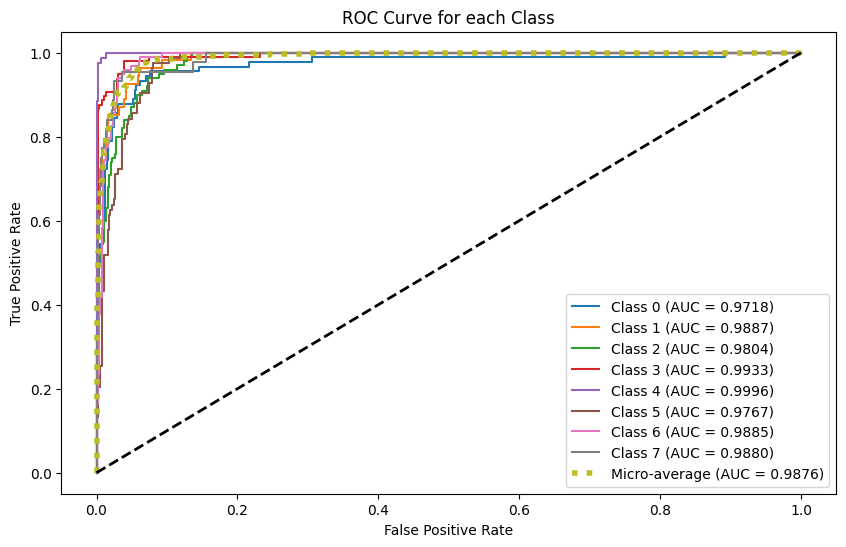

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

test_steps = test_generator.samples // test_generator.batch_size
y_test = []
y_score = []

for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_test.append(y_batch)
    y_score.append(model_resnet50.predict(x_batch))


y_test = np.concatenate(y_test)
y_score = np.concatenate(y_score)

y_test_bin = label_binarize(y_test, classes=range(test_generator.num_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each Class')
plt.legend(loc='lower right')

plt.show()

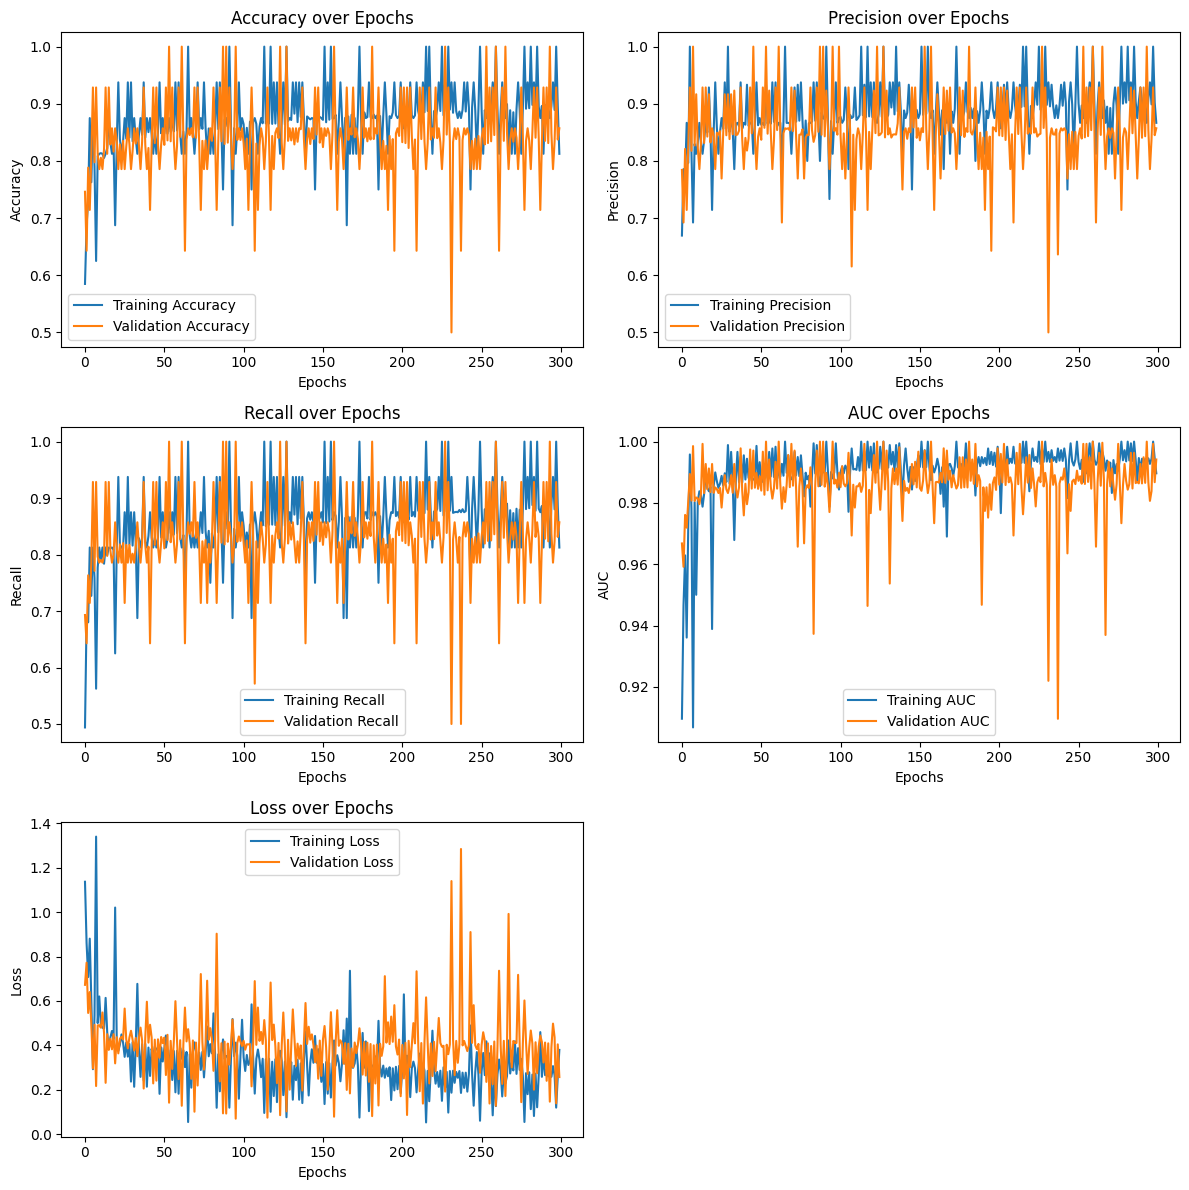

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(history.history['Precision'], label='Training Precision')
plt.plot(history.history['val_Precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(history.history['Recall'], label='Training Recall')
plt.plot(history.history['val_Recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(3, 2, 4)
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Loss plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


if 'lr' in history.history:
    plt.subplot(3, 2, 6)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

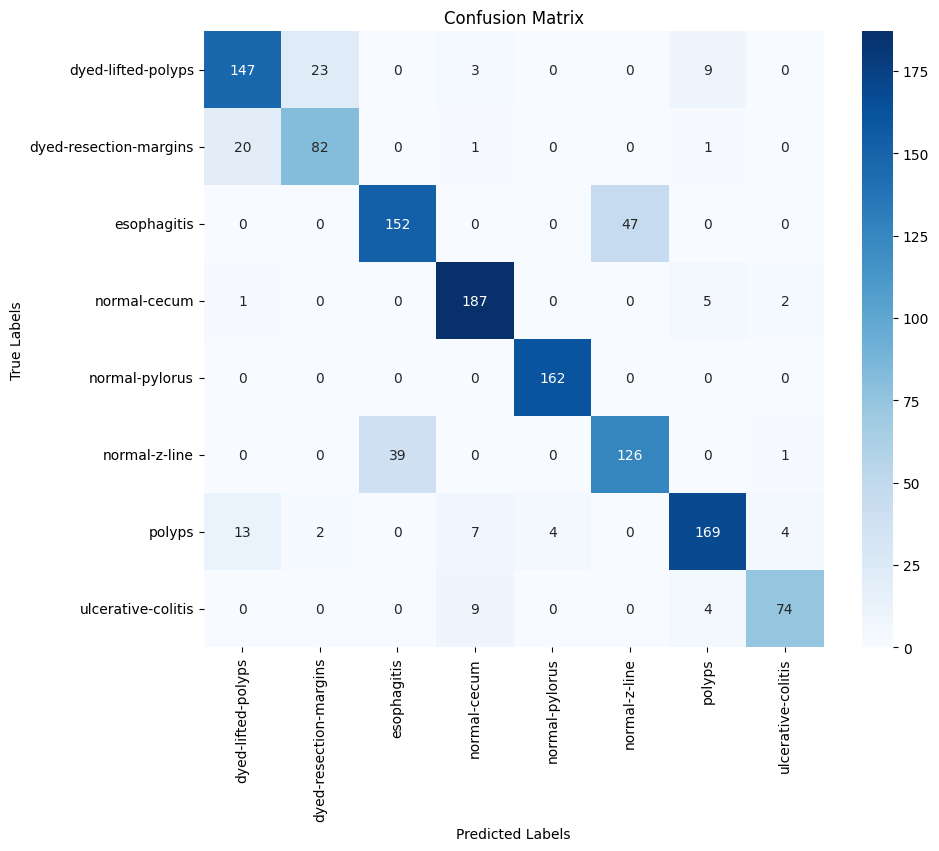

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.81      0.81      0.81       182
dyed-resection-margins       0.77      0.79      0.78       104
           esophagitis       0.80      0.76      0.78       199
          normal-cecum       0.90      0.96      0.93       195
        normal-pylorus       0.98      1.00      0.99       162
         normal-z-line       0.73      0.76      0.74       166
                polyps       0.90      0.85      0.87       199
    ulcerative-colitis       0.91      0.85      0.88        87

              accuracy                           0.85      1294
             macro avg       0.85      0.85      0.85      1294
          weighted avg       0.85      0.85      0.85      1294



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_generator.reset()


true_labels = []
predicted_probs = []


for i in range(len(validation_generator)):
    imgs, labels = next(validation_generator)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_probs.extend(np.argmax(model_resnet50.predict(imgs), axis=1))


cm = confusion_matrix(true_labels, predicted_probs)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predicted_probs, target_names=list(validation_generator.class_indices.keys()))) 